In [2]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps, ImageFilter

from fastprogress import progress_bar

from util import make_shepp_logan_image, line_mask

# Problem setup

In [7]:
# Problem parameters
spatial_resolution = 64
#freq = np.ceil(spatial_resolution*np.pi/8)
freq = np.ceil(spatial_resolution*np.pi/8)

# Create angles and FFT mask
thetas = np.arange(0, 180, 180/freq)
phantom_resolution = 2*spatial_resolution + 1
phantom = make_shepp_logan_image(phantom_resolution)
L = len(thetas)
Ny = 2*spatial_resolution + 1
Nx = 2*spatial_resolution + 1
R, Mh, mi, mhi = line_mask(L, Ny, Nx)
R = R.astype(np.float64)
BPR = np.real( np.fft.ifft2( R*np.fft.fft2(phantom) ) ) # backprojection

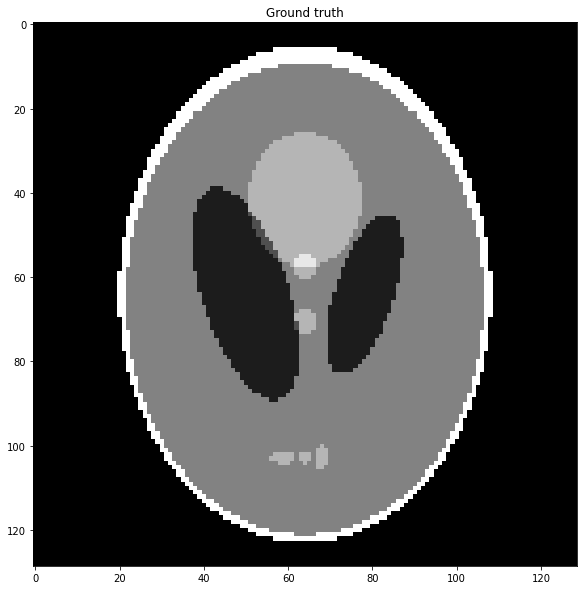

In [8]:
plt.figure(figsize=(10,10))
plt.title("Ground truth")
plt.imshow(phantom, cmap="gray")
plt.show()

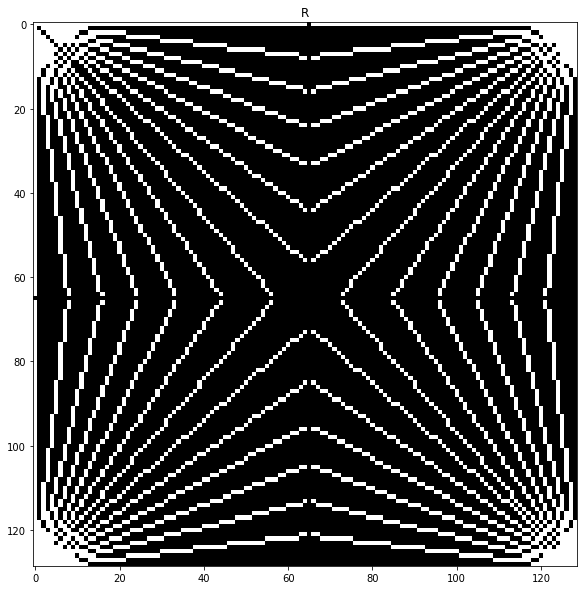

In [9]:
plt.figure(figsize=(10,10))
plt.title("R")
plt.imshow(R, cmap="gray")
plt.show()

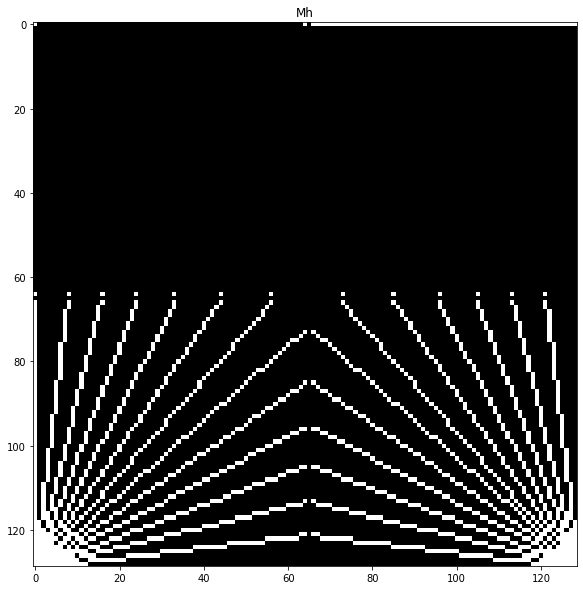

In [10]:
plt.figure(figsize=(10,10))
plt.title("Mh")
plt.imshow(Mh, cmap="gray")
plt.show()

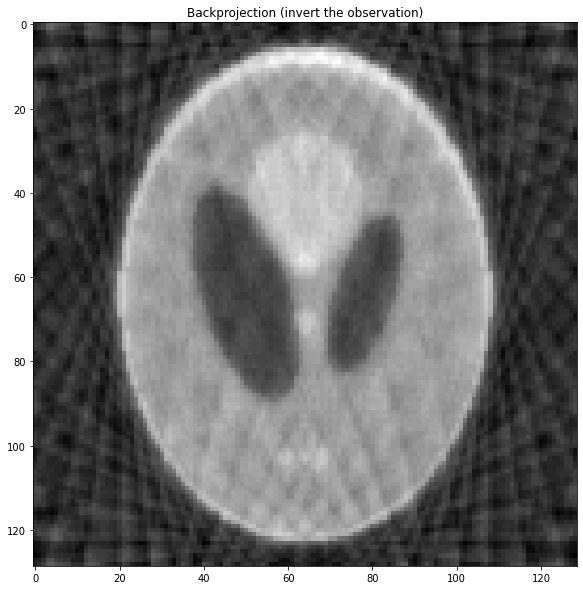

In [11]:
plt.figure(figsize=(10,10))
plt.title("Backprojection (invert the observation)")
plt.imshow(BPR, cmap="gray")
plt.show()

### Finally, set up the TV matrix.

In [12]:
import scipy.sparse as sp

In [13]:
tv_mat = sp.eye(2*spatial_resolution + 1) - sp.diags( np.ones(2*spatial_resolution) , offsets=1)
tv_mat = tv_mat[:-1,:] # Remove last row to remove zero BC
tv_mat_t = tv_mat.T
tv_mat_t_tv_mat = tv_mat_t @ tv_mat

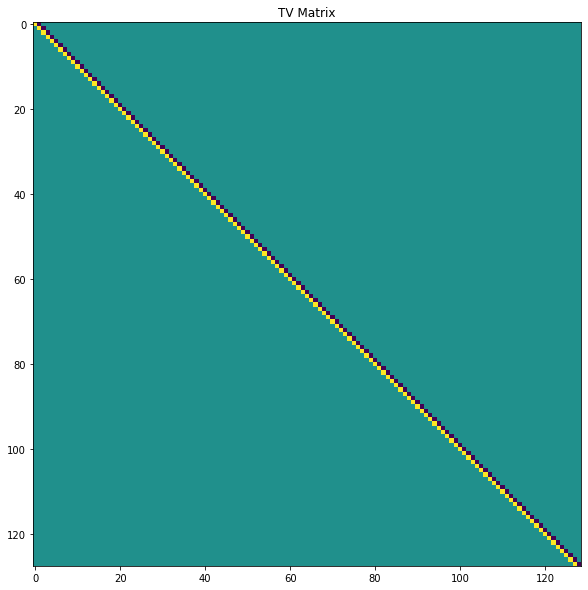

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(tv_mat.toarray())
plt.title("TV Matrix")
plt.show()

# Now the algorithm

In [30]:
# Masked Fourier observation
f = R*np.fft.fft2(phantom)

uk = np.fft.ifft2(R*f)

dk_x = np.zeros((2*spatial_resolution, 2*spatial_resolution + 1))
dk_y = np.zeros((2*spatial_resolution + 1, 2*spatial_resolution))

bk_x = dk_x.copy()
bk_y = dk_y.copy()
fk = f.copy()

# Optimization parameters
n_inner = 1 # 1
n_outer = 35 # 35
lam = 1.0 # 1
cg_max_its = 200 # 200

# for j_outer in progress_bar(range(n_outer)):
#     for j_inner in range(n_inner):

for j_outer in progress_bar(range(n_outer)):
    for j_inner in range(n_inner):

        rhs = np.fft.ifft2(R*fk)
        rhs += lam * tv_mat_t @ (dk_x-bk_x)
        rhs += lam * (dk_y-bk_y) @ tv_mat

        ### L2 minimization step
        r = rhs - np.fft.ifft2(R*np.fft.fft2(uk))
        r -= lam * tv_mat_t_tv_mat @ uk
        r -= lam * uk @ tv_mat_t_tv_mat

        # Flatten
        r = r.flatten()
        uk = uk.flatten()

        # Conjugate gradient sub-problem
        p = r.copy()
        rsold = np.conjugate(r.T) @ r # dot product
        for i in range(cg_max_its): # subiterations
            p = np.reshape(p, (2*spatial_resolution+1, 2*spatial_resolution+1))
            
            Ap = np.fft.ifft2(R*np.fft.fft2(p))
            Ap += lam * tv_mat_t_tv_mat @ p
            Ap += lam * p @ tv_mat_t_tv_mat

            # Flatten
            Ap = Ap.flatten()
            p = p.flatten()

            # Calculate stuff
            alpha = rsold/(np.conjugate(p.T) @ Ap) # has dot product in denominator
            uk += alpha*p
            r -= alpha*Ap
            rsnew = np.conjugate(r.T) @ r # dot product
            if np.sqrt(rsnew) < 1e-10:
                break
            
            p = r + (rsnew/rsold)*p
            rsold = rsnew
        
        uk = np.reshape(uk, (2*spatial_resolution+1, 2*spatial_resolution+1))
        

        ### L1 optimization of dk directly by shrink operator
        sk_x = np.sqrt( (tv_mat @ uk + bk_x)**2 )
        # print((tv_mat @ uk + bk_x))
        # print(type((tv_mat @ uk + bk_x)))
        # print((tv_mat @ uk + bk_x)**2)
        dk_x = np.maximum( np.abs(sk_x)-1/lam, 0) * (tv_mat @ uk + bk_x)/sk_x
        #print( np.maximum( np.abs(sk_x)-1/lam, 0))
        bk_x = bk_x + tv_mat @ uk - dk_x
        sk_y = np.sqrt( (uk @ tv_mat_t + bk_y)**2 )
        dk_y = np.maximum( np.abs(sk_y)-1/lam, 0) * ( uk @ tv_mat_t + bk_y)/sk_y
        bk_y = bk_y + uk @ tv_mat_t - dk_y

    # Update fk
    fk += f - R*np.fft.fft2(uk)

# Final solution is real part of uk
tv_reconstruction = np.real(uk)


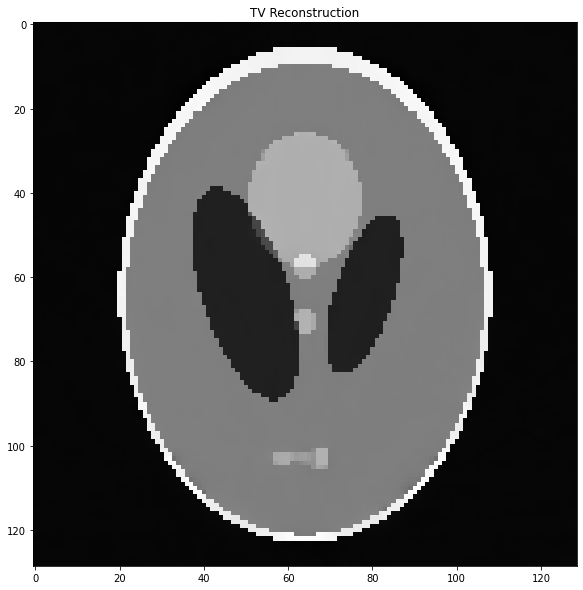

In [31]:
plt.figure(figsize=(10,10))
plt.title("TV Reconstruction")
plt.imshow(tv_reconstruction, cmap="gray")
plt.show()

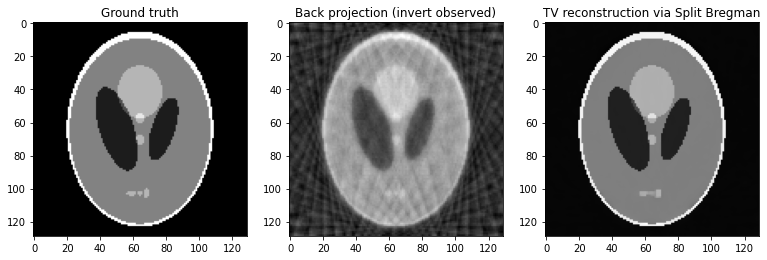

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(13,13))

axs[0].imshow(phantom, cmap="gray")
axs[0].set_title("Ground truth")

axs[1].imshow(BPR, cmap="gray")
axs[1].set_title("Back projection (invert observed)")

axs[2].imshow(tv_reconstruction, cmap="gray")
axs[2].set_title("TV reconstruction via Split Bregman")

plt.show()